In [ ]:
import pandas as pd
import numpy as np
import re
import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Definiciones

In [ ]:
meses = ['202112','202201','202202','202203','202204']   # Meses a analizar
seccion = 'politica'   # Sección para filtrar, si queda en blanco se usan todas las noticias
objeto = 3   # 1 solo titulos 2 solo cuerpo 3 ambos (default)

### Descarga y lectura del dataset

In [ ]:
# Leemos todos los csvs mensuales
# Integramos todo en un único DataFrame

files = {}

for m in meses:
    url = 'https://github.com/fermasia/news-base/blob/main/files/' + m + '.csv.gz?raw=true'
    files[m] = pd.read_csv(url, compression='gzip')
    
df = pd.concat(files.values(), ignore_index=True)

#del files

In [ ]:
for m in meses:
    print(m,len(files[m].link))

202112 25090
202201 30363
202202 23109
202203 18172
202204 13931


### Vamos a construir un campo que tenga el dato de AAAAMM (YYYYMM)
##### Para agrupar luego por medio y por mes-año

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['yyyymm'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str)

##### Aprovechamos a ordenar las filas por medio y AAAAMM y reseteamos los índices para luego poder joinear

In [ ]:
df.sort_values(by=['yyyymm','source'],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True) 

### Crear el corpus filtrando por sección

In [ ]:
if seccion == '':
    corpus_df = df
else:
    corpus_df = df[df.category == seccion]
    
corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']
sources_df = corpus_df['source'] # conservamos los origenes y el mes año para unir luego de procesar

if  objeto == 1:
    corpus_df = pd.DataFrame(corpus_df.title)
    col = 'title'

elif objeto == 2:
    corpus_df = pd.DataFrame(corpus_df.text)
    col = 'text'
else:
    corpus_df = pd.DataFrame(corpus_df.title + ' ' + corpus_df.text)
    col = 0

corpus_df.rename(columns={col:'text'},inplace=True)
corpus_df['text'] = corpus_df.text.astype(str)
corpus_bert = corpus_df['text'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%;,"“”', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.replace('\xa0',' ')
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = text.replace('?',' ')
    text = text.replace('¿',' ')
    # Eliminamos los caracteres especiales
    text = re.sub(r'\W', ' ', str(text))
    # Eliminado las palabras que tengo un solo caracter
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Sustituir los espacios en blanco en uno solo
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

corpus_df['text'] = corpus_df.text.apply(clean_text)

In [ ]:
stopwords_es = pd.read_csv('https://raw.githubusercontent.com/jbagnato/machine-learning/master/nlp/spanish.txt',header=None)[0].to_list()
aditional_sw = ['ciento','gobierno','argentina','window','t','terminación','año','si','no','dijo','país','política','años','año','uno','dos','tres','cuatro','cinco']
stopwords_es = stopwords_es + aditional_sw 

def remove_stopwords(text):
    stripped_text = [w for w in text.split() if w not in stopwords_es and not w.isdigit()]
    return ' '.join(word for word in stripped_text)

def remove_word(text,word='terminación'):
    stripped_text = [w for w in text.split() if word not in w]
    return ' '.join(word for word in stripped_text)

corpus_df.text = corpus_df.text.apply(remove_stopwords)
corpus_df.text = corpus_df.text.apply(remove_word)

In [ ]:
complete_df = pd.merge(corpus_df, sources_df, left_index=True, right_index=True)

## Vamos a hacer WordClouds por mes y por medio

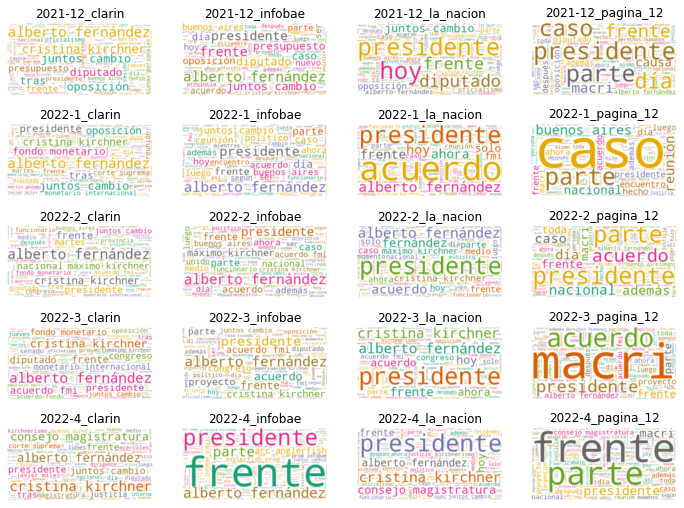

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def crear_wordclouds(df):
    wc = WordCloud(background_color="white", colormap="Dark2",
                   max_font_size=150, random_state=42)

    plt.rcParams['figure.figsize'] = [12,9]

    sources = complete_df.source.unique().tolist()

    index = 0

    width = 4
    height = int(np.round(len(complete_df.source.unique()) / width,0))

    for source in sources:
        index += 1
        bag = df.text[df.source == source].str.cat(sep=' ')
        wc.generate(bag)
        plt.subplot(height, width, index)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(source)

    plt.show()
    
crear_wordclouds(complete_df)

# Detección de Tópicos

In [ ]:
import json, re
import pandas as pd 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer

In [ ]:
tokenizer = ToktokTokenizer() 
corpus_df["Tokens"] = corpus_df.text.apply(tokenizer.tokenize)
corpus_df.head()

,text,Tokens
35,juan manzur wado pedro cabecera mesa rosada co...,"[juan, manzur, wado, pedro, cabecera, mesa, ro..."
36,video piñas empujones elección presidencia juv...,"[video, piñas, empujones, elección, presidenci..."
37,derrota grande difícil imaginar derrota grande...,"[derrota, grande, difícil, imaginar, derrota, ..."
38,agustín rossi pasó peronismo ex ministro defen...,"[agustín, rossi, pasó, peronismo, ex, ministro..."
39,debilidades crecieron últimamente esteban bull...,"[debilidades, crecieron, últimamente, esteban,..."


In [ ]:
stemmer = SnowballStemmer("spanish")

def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

corpus_df["Stems"] = corpus_df.Tokens.apply(stem_palabras)

corpus_df.head()

,text,Tokens,Stems
35,juan manzur wado pedro cabecera mesa rosada co...,"[juan, manzur, wado, pedro, cabecera, mesa, ro...","[juan, manzur, wad, pedr, cabecer, mes, ros, c..."
36,video piñas empujones elección presidencia juv...,"[video, piñas, empujones, elección, presidenci...","[vide, piñ, empujon, eleccion, president, juve..."
37,derrota grande difícil imaginar derrota grande...,"[derrota, grande, difícil, imaginar, derrota, ...","[derrot, grand, dificil, imagin, derrot, grand..."
38,agustín rossi pasó peronismo ex ministro defen...,"[agustín, rossi, pasó, peronismo, ex, ministro...","[agustin, rossi, pas, peron, ex, ministr, defe..."
39,debilidades crecieron últimamente esteban bull...,"[debilidades, crecieron, últimamente, esteban,...","[debil, crec, ultim, esteb, bullrich, acto, pr..."


In [ ]:
#!pip install pyLDAvis
#!python -m spacy download es_core_news_md

In [ ]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
data_words = corpus_df.Tokens.to_list()

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['juan_manzur', 'wado_pedro', 'cabecera', 'mesa', 'rosada', 'concejalas', 'edilas', 'juan_manzur', 'wado_pedro', 'sentaron', 'lunes', 'cabecera', 'mesa', 'trabajo', 'particular', 'jefe_gabinete', 'ministro', 'interior', 'recibieron', 'casa_rosada', 'representantes', 'red', 'federal', 'concejalas', 'federación', 'municipios', 'fam', 'encuentro', 'abordaron', 'temas', 'bien', 'diversos', 'nutrido_grupo', 'edilas', 'destacó', 'comunicado']


In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) #'ADJ', 'VERB', 'ADV'

print(data_lemmatized[:1])

In [ ]:
print(data_lemmatized[:1])

[['mesar', 'lunes', 'trabajar', 'representante', 'encontrar', 'temer', 'comunicar']]


In [ ]:
data = []
for sentence in data_words_bigrams:
  data.append([word for word in sentence if len(word) > 3])

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [ ]:
diccionario = Dictionary(data)
print(f'Número de tokens: {len(diccionario)}')

diccionario.filter_extremes(no_below=25, no_above = 0.8)
print(f'Número de tokens limpiando palabras por frecuencia: {len(diccionario)}')

Número de tokens: 107693
Número de tokens limpiando palabras por frecuencia: 10352


In [ ]:
# Creamos el corpus 
corpus = [diccionario.doc2bow(noticia) for noticia in data]

# Mostramos el BOW de una noticia
print(corpus[6])

[(13, 1), (25, 1), (33, 1), (40, 2), (84, 1), (134, 1), (135, 1), (136, 1), (137, 1), (138, 1), (139, 2), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1)]


In [ ]:
topics = 30
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=topics, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

In [ ]:
for k in range(2,25): # Train LDA on different values of k
    print('Round: '+str(k))
    LDA = gensim.models.ldamulticore.LdaMulticore
    ldamodel = LDA(corpus=corpus, num_topics=k, id2word = diccionario, passes=20, iterations=100,
                   chunksize = 10000, eval_every = 10, random_state=20)
    ldamodel.save(f"ldamodel_for_{k}topics_Run_10")
    pprint(ldamodel.print_topics())

Round: 2
[(0,
  '0.005*"justicia" + 0.003*"juez" + 0.003*"nacional" + 0.003*"causa" + '
  '0.003*"federal" + 0.003*"parte" + 0.003*"caso" + 0.003*"corte" + '
  '0.003*"judicial" + 0.003*"presidente"'),
 (1,
  '0.009*"presidente" + 0.009*"acuerdo" + 0.006*"frente" + '
  '0.006*"alberto_fernández" + 0.005*"nacional" + 0.004*"ministro" + '
  '0.004*"juntos_cambio" + 0.004*"congreso" + 0.004*"oposición" + '
  '0.003*"proyecto"')]
Round: 3
[(0,
  '0.004*"nacional" + 0.003*"personas" + 0.003*"trabajo" + 0.003*"justicia" + '
  '0.003*"parte" + 0.003*"después" + 0.002*"hace" + 0.002*"ministro" + '
  '0.002*"poder" + 0.002*"bonaerense"'),
 (1,
  '0.010*"acuerdo" + 0.009*"presidente" + 0.007*"frente" + '
  '0.006*"alberto_fernández" + 0.005*"nacional" + 0.005*"juntos_cambio" + '
  '0.004*"ministro" + 0.004*"oposición" + 0.004*"congreso" + 0.004*"proyecto"'),
 (2,
  '0.006*"presidente" + 0.006*"justicia" + 0.005*"corte" + 0.005*"juez" + '
  '0.004*"federal" + 0.004*"corte_suprema" + 0.004*"cristi

In [ ]:
import gensim
coherence = []
for k in range(2,25):
    LDA = gensim.models.ldamulticore.LdaMulticore
    ldamodel = LDA.load(f"ldamodel_for_{k}topics_Run_10")
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=data, dictionary=diccionario, coherence='c_v')
    coherence.append((k, 'default', 'default', cm.get_coherence()))

FileNotFoundError: ignored

In [ ]:
pd.DataFrame(coherence, columns=['LDA_Model','alpha','eta','coherence_score']).to_csv('coherence_matrix_10.csv', index=False)

In [ ]:
mat = pd.read_csv('coherence_matrix_10.csv')
mat.reset_index(drop=True)
mat

In [ ]:
# Show graph
x = range(2,25)
plt.plot(x, mat['coherence_score'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show() # Num Topics = 4 is having highest coherence score.

In [ ]:
topicos = lda.print_topics(num_words=5, num_topics=topics)
for topico in topicos:
    print(topico)

(0, '0.029*"milei" + 0.026*"diputado" + 0.024*"macri" + 0.021*"sostuvo" + 0.021*"nacional"')
(1, '0.016*"países" + 0.015*"venezuela" + 0.014*"cancillería" + 0.013*"derechos_humanos" + 0.013*"argentino"')
(2, '0.023*"salud" + 0.018*"covid" + 0.012*"personas" + 0.011*"casos" + 0.010*"pandemia"')
(3, '0.009*"puede" + 0.008*"ahora" + 0.008*"hacer" + 0.007*"hace" + 0.006*"gente"')
(4, '0.023*"frente" + 0.019*"marcha" + 0.019*"trabajadores" + 0.014*"social" + 0.012*"dirigentes"')
(5, '0.038*"macri" + 0.021*"espionaje" + 0.019*"inteligencia" + 0.017*"macrismo" + 0.016*"mauricio_macri"')
(6, '0.064*"ucrania" + 0.057*"rusia" + 0.043*"guerra" + 0.026*"putin" + 0.016*"mundo"')
(7, '0.051*"mujeres" + 0.039*"images_arcpublishing" + 0.039*"us_east" + 0.032*"gallardo" + 0.032*"com_infobae"')
(8, '0.031*"ciudad" + 0.025*"nacional" + 0.020*"provincias" + 0.019*"provincia" + 0.015*"nación"')
(9, '0.050*"corte" + 0.038*"consejo_magistratura" + 0.029*"corte_suprema" + 0.025*"consejo" + 0.023*"justicia"')


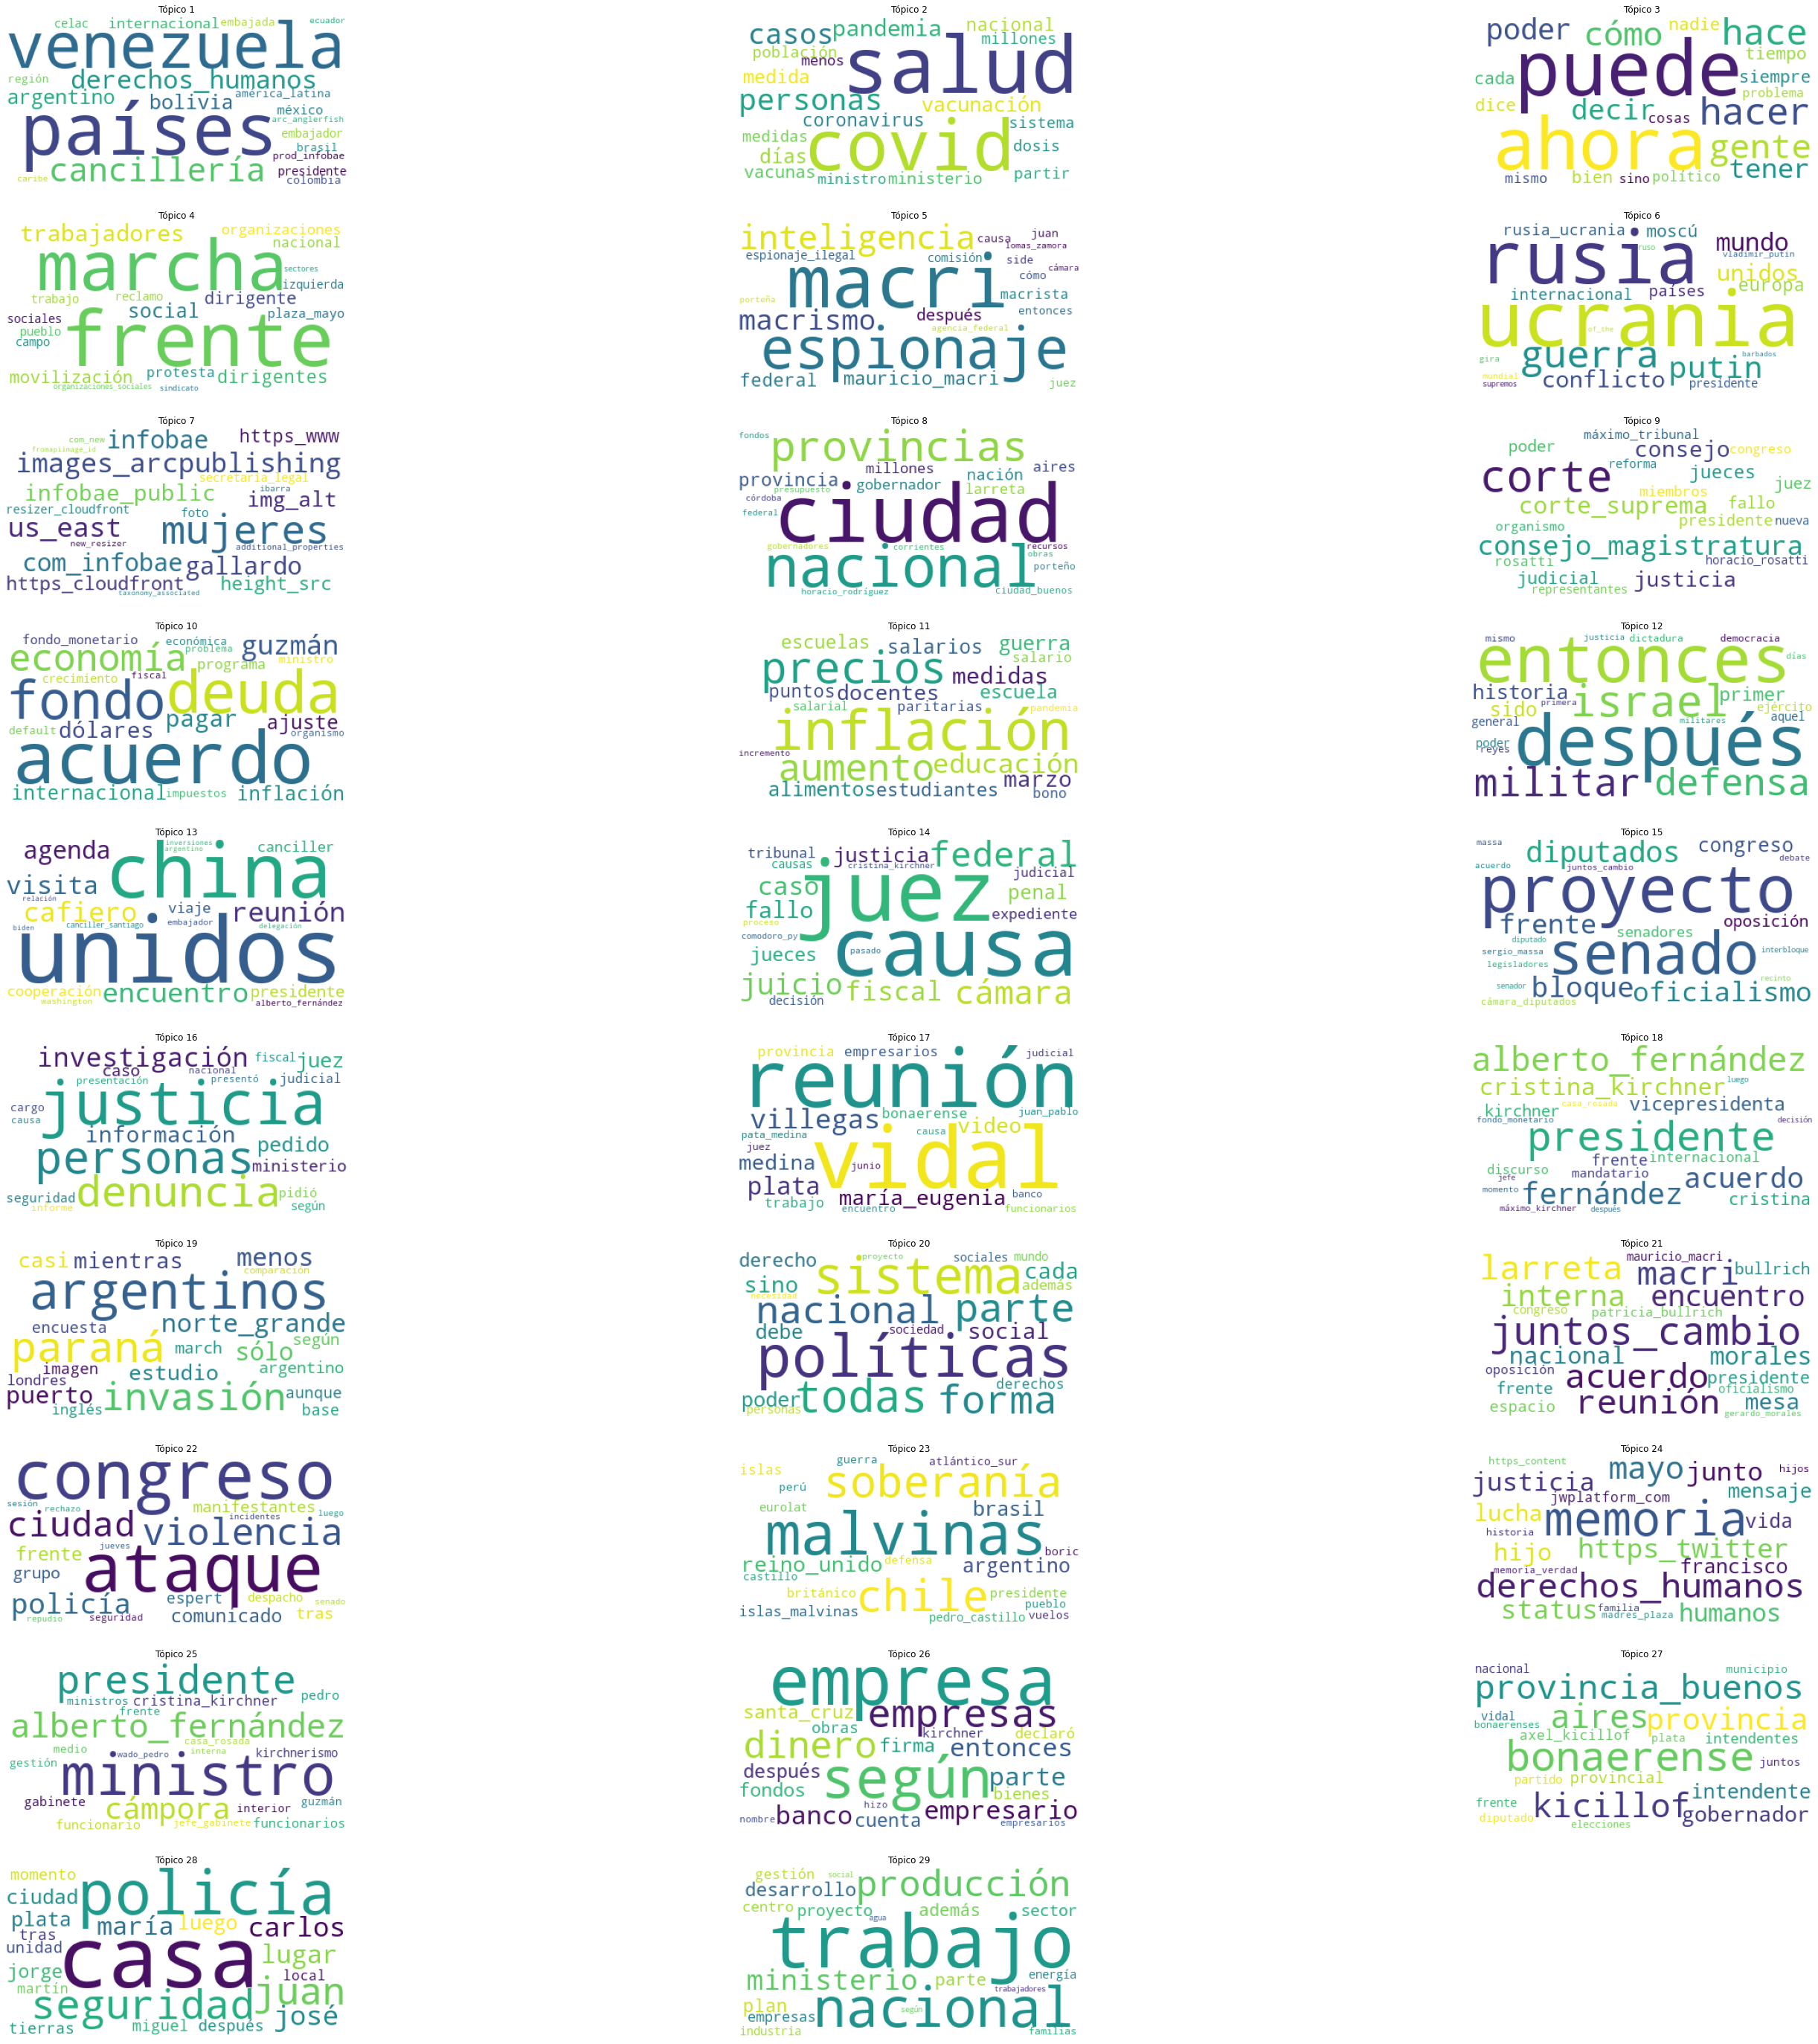

In [ ]:
cant_topicos = topics
columnas = 3
if (cant_topicos % columnas) > 0:
    filas = int(cant_topicos/columnas) + 1
else:
    filas = int(cant_topicos/columnas)

for i in range(1, cant_topicos):
    plt.subplot(filas,columnas,i)
    plt.rcParams['figure.figsize'] = [10,12]
#     plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
plt.show()